In [65]:
# ## 1. Setup & Imports

# Standard library imports

import os
import re
import pandas as pd
import nltk
import joblib
import matplotlib.pyplot as plt
# NLP & ML imports

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [66]:
# Download required NLTK data

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger') # Download the POS tagger data


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [67]:
# 2. Load & Combine Datasets

# ---- A) Load FastText data from test.ft.txt ----

fast_data = []
with open('test.txt', 'r', encoding='utf-8') as f:
    for line in f:
        lbl, txt = line.strip().split(' ', 1)
        lab = int(lbl.replace('__label__','')) - 1
        if lab == 1:  # remap FastText positive=2
            lab = 2
        fast_data.append({'text': txt, 'label': lab})

     # Build DataFrame
df_fast = pd.DataFrame(fast_data)

In [68]:
# ---- B) Load Shopee reviews CSV ----

df_shopee = pd.read_csv('SHOPEE_REVIEWS.csv')
df_shopee = df_shopee.rename(columns={'review_text':'text','review_rating':'rating'})

# Map star ratings to sentiment labels

def map_rating(r):
    if r >= 4:   return 2  # Positive
    if r == 3:   return 1  # Neutral
    return 0               # Negative
df_shopee['label'] = df_shopee['rating'].apply(map_rating)

# Keep only needed columns

df_shopee = df_shopee[['text','label']]

In [69]:
# ---- C) Combine & shuffle both datasets ----

df = pd.concat([df_fast, df_shopee], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [70]:
# Quick stats

print("Total examples:", len(df))
print("Label distribution:\n", df['label'].value_counts())


Total examples: 1182079
Label distribution:
 label
2    845615
0    310769
1     25695
Name: count, dtype: int64


In [71]:
# 3. Load Stopwords & Lemmatizer


# Use English stopwords only
stop_words = set(stopwords.words('english'))


# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [72]:
# 4. Preprocessing Function

def preprocess(text):
    """
    1) Lowercase
    2) Remove HTML tags
    3) Remove punctuation
    4) Tokenize
    5) Remove stopwords
    6) Lemmatize
    """
    text = text.lower()
    text = re.sub(r"<[^>]+>", "", text)          # Strip HTML
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)   # Strip punctuation
    tokens = nltk.word_tokenize(text)            # Tokenize
    # Lemmatize and remove stopwords
    tokens = [
        lemmatizer.lemmatize(t)
        for t in tokens
        if t not in stop_words
    ]
    return " ".join(tokens)

df['text'] = df['text'].fillna('')

# Apply preprocessing to all texts
df['clean_text'] = df['text'].apply(preprocess)




In [73]:
# 5. N‑gram Modeling: Top Bigrams
# Extract and rank the most frequent 2‑word phrases (bigrams) in the corpus.

# %%
from sklearn.feature_extraction.text import CountVectorizer

# Build a bigram-only CountVectorizer
bigram_vect = CountVectorizer(ngram_range=(2,2), max_features=30)
X_bigrams = bigram_vect.fit_transform(df['clean_text'])

# Sum up counts for each bigram
counts = X_bigrams.sum(axis=0).A1
bigrams = bigram_vect.get_feature_names_out()
top_bigrams = sorted(zip(counts, bigrams), reverse=True)

print("Top 30 Bigrams:")
for cnt, gram in top_bigrams:
    print(f"{gram}: {int(cnt)}")

Top 30 Bigrams:
free shipping: 19255
nice app: 12621
good quality: 11624
read book: 11088
online shopping: 10745
waste money: 10020
easy use: 9812
thank shopee: 9643
customer service: 9274
year old: 8769
dont know: 8456
salamat shopee: 8340
good app: 8209
would recommend: 8117
sa shopee: 7532
great app: 7510
love shopee: 7170
much better: 7147
one best: 7107
first time: 7049
shopping app: 6992
highly recommend: 6763
waste time: 6654
love app: 6648
fast delivery: 6564
sa mga: 6543
shipping fee: 6468
even though: 6102
year ago: 5997
dont waste: 5977


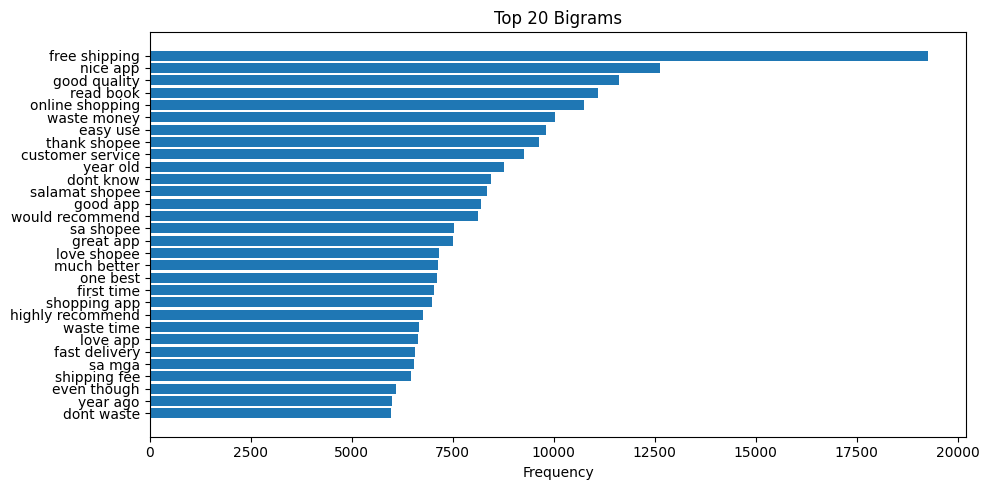

In [74]:
import matplotlib.pyplot as plt

counts, grams = zip(*top_bigrams)
plt.figure(figsize=(10,5))
plt.barh(grams[::-1], counts[::-1])
plt.title("Top 20 Bigrams")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [76]:
# 6. Feature Extraction (TF-IDF)


# Create TF-IDF vectorizer, limit to top 5000 features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])
y = df['label']

In [77]:
# 7. Train/Test Split

# Stratified split to maintain class proportions

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [78]:
# 8. Train Classifier

# Train multinomial logistic regression

clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000
)
clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [79]:
# 9. Evaluation: Classification Report

# Predict on test set

y_pred = clf.predict(X_test)

# Print detailed metrics

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83     62154
           1       0.22      0.01      0.01      5139
           2       0.91      0.96      0.93    169123

    accuracy                           0.90    236416
   macro avg       0.66      0.59      0.59    236416
weighted avg       0.88      0.90      0.89    236416

Confusion Matrix:
 [[ 50129     51  11974]
 [  1804     37   3298]
 [  7220     84 161819]]


In [81]:
# 10. POS Tagging Samples (Optional Extra)

nltk.download('averaged_perceptron_tagger_eng')

# %%
# Show POS tags for first 5 cleaned sentences
for sent in df['clean_text'].head(5):
    tags = nltk.pos_tag(nltk.word_tokenize(sent))
    print(tags)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


[('nice', 'JJ')]
[('usedfull', 'JJ'), ('apps', 'NN')]
[('puleeze', 'NN'), ('real', 'JJ'), ('earth', 'NN'), ('otherwise', 'RB'), ('intelligent', 'JJ'), ('people', 'NNS'), ('fall', 'VBP'), ('kindof', 'JJ'), ('scam', 'NN'), ('author', 'NN'), ('information', 'NN'), ('channeled', 'VBD'), ('toher', 'RB'), ('sorry', 'JJ'), ('thing', 'NN'), ('identified', 'VBN'), ('thisvoice', 'JJ'), ('jesus', 'NN'), ('puleeze', 'NN'), ('course', 'NN'), ('take', 'VB'), ('work', 'NN'), ('itand', 'NN'), ('shame', 'NN'), ('marianne', 'NNP'), ('williamson', 'NN'), ('spectacular', 'JJ'), ('huckster', 'NN'), ('latching', 'VBG'), ('onto', 'IN'), ('nonsense', 'JJ'), ('reali', 'NN'), ('know', 'VBP'), ('relgion', 'NN'), ('mean', 'JJ'), ('lot', 'NN'), ('people', 'NNS'), ('hope', 'VBP'), ('get', 'VB'), ('better', 'JJR'), ('guidance', 'NN'), ('phoneybaloney', 'NN'), ('nonsense', 'NN'), ('shame', 'NN')]
[('good', 'JJ')]
[]


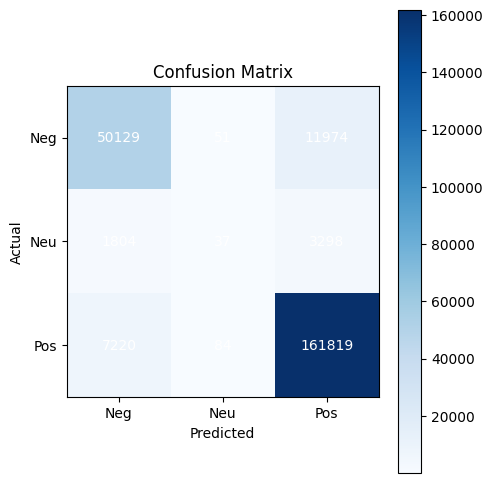

In [82]:
# 11. Confusion Matrix Heatmap (Pure Matplotlib)

# %%
cm = confusion_matrix(y_test, y_pred)
labels = ['Neg', 'Neu', 'Pos']

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [83]:
# 12. Save Model & Vectorizer


# Ensure models directory exists
os.makedirs('models', exist_ok=True)


# Persist classifier and vectorizer
joblib.dump(clf, 'models/sentiment_model.pkl')
joblib.dump(vectorizer, 'models/vectorizer.pkl')

['models/vectorizer.pkl']

In [84]:
print("Saved: models/sentiment_model.pkl and models/vectorizer.pkl")

Saved: models/sentiment_model.pkl and models/vectorizer.pkl
